In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Downloading files

In [6]:
!curl -O "https://raw.githubusercontent.com/SaminRK/scPSS-reproducibility/refs/heads/master/data_downloaders/download_calcagno.sh"
!curl -O "https://raw.githubusercontent.com/SaminRK/scPSS-reproducibility/refs/heads/master/preprocessors/preprocess_calcagno.py"
!curl -O "https://raw.githubusercontent.com/SaminRK/scPSS-reproducibility/refs/heads/master/utils/mean_margin.py"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1445  100  1445    0     0  27941      0 --:--:-- --:--:-- --:--:-- 28333
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5339  100  5339    0     0  98989      0 --:--:-- --:--:-- --:--:--   98k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   987  100   987    0     0  18592      0 --:--:-- --:--:-- --:--:-- 18980


In [7]:
!chmod +x download_calcagno.sh

In [8]:
!./download_calcagno.sh data

==> Downloading Zenodo ZIP...
--2025-07-23 14:47:04--  https://zenodo.org/records/7055957/files/Nikatag/Single-Cell-Spatial-Transcriptomics-for-Border-zone-BZ_Cell_Mapping.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 416 REQUESTED_RANGE_NOT_SATISFIABLE

    The file is already fully retrieved; nothing to do.

==> Unzipping Zenodo ZIP...
Archive:  /content/data/Single-Cell-Spatial-Transcriptomics-for-Border-zone-BZ_Cell_Mapping_zenodo.zip
8f7e1d14be5fa874c92bff1d8cb282eb9aa613fd
  inflating: /content/data/Nikatag-Single-Cell-Spatial-Transcriptomics-for-Border-zone-8f7e1d1/BZ_spatial_integration_mapping.R  
  inflating: /content/data/Nikatag-Single-Cell-Spatial-Transcriptomics-for-Border-zone-8f7e1d1/Spatial_object_integrated@meta.data.csv  
  inflating: /content/data/Nikatag-Single-Cell-Spatial-Transcriptomics-for-Border-

## scPSS

In [13]:
!pip install git+https://github.com/SaminRK/scPSS.git

  Cloning https://github.com/SaminRK/scPSS.git to /tmp/pip-req-build-ujkk4z9v
  Running command git clone --filter=blob:none --quiet https://github.com/SaminRK/scPSS.git /tmp/pip-req-build-ujkk4z9v
  Resolved https://github.com/SaminRK/scPSS.git to commit c16c71713e6a618ed6196b83b1dc3daa30838e1a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of umap-learn to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 137.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.4 MB/s eta 0:00:00
  Created wheel for scPSS: f

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
## Modify to the source directory of single cell data
ROOT_PATH = 'data'

In [14]:
import scanpy as sc
import pandas as pd

In [15]:
metadata_sc = pd.read_csv(f'{ROOT_PATH}/sn_wc_object_integrated@meta.data.csv', index_col=0)
metadata_sc_t = metadata_sc.rename(index=lambda x: x.split('_')[0])
metadata_sc_t['obs_names'] = metadata_sc_t.index

In [16]:
def get_anndata(mtx_path_id, metadata_orig_id):
    PATH = f'{ROOT_PATH}/{mtx_path_id}'
    ad = sc.read_10x_mtx(PATH)
    ad.obs = ad.obs.rename(index=lambda x: x.split('-')[0])
    A = metadata_sc_t[metadata_sc_t['orig.ident'] == metadata_orig_id]

    ad.obs = ad.obs.merge(A, left_index=True, right_index=True, how='left')

    return ad

In [17]:
def pp_anndata(ad, n_top_genes=None, plot=False):
    ad.var_names_make_unique()

    sc.pp.filter_cells(ad, min_genes=200)
    sc.pp.filter_genes(ad, min_cells=3)

    ad.var['mt'] = ad.var_names.str.startswith('mt-')
    sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    if plot:
        sc.pl.violin(ad, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
                jitter=0.4, multi_panel=True)
        sc.pl.scatter(ad, x='total_counts', y='pct_counts_mt')
        sc.pl.scatter(ad, x='total_counts', y='n_genes_by_counts')

    ad = ad[ad.obs.pct_counts_mt <= 5, :]

    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

    if n_top_genes is not None:
        sc.pp.highly_variable_genes(ad, n_top_genes=n_top_genes)
        ad.raw = ad
        ad = ad[:, ad.var.highly_variable]

    if plot:
        sc.pl.highly_variable_genes(ad)

    return ad

## Prepare training and testing dataset

In [18]:
def get_mtx_path_id_metadata_orig_id(problem_key):
    exp_meta_keys = {
        'exp_0': {
            'reference': [
                ('snd0_1', 'D0'),
                ('snd0_2', 'D0'),
            ],
            'query': [
                ('snd0_3', 'NoMI_Nuclei'),
            ]
        },
        'exp_1': {
            'reference': [
                ('snd0_1', 'D0'),
                ('snd0_3', 'NoMI_Nuclei'),
            ],
            'query': [
                ('snd0_2', 'D0'),
            ]
        },
        'exp_2': {
            'reference': [
                ('snd0_2', 'D0'),
                ('snd0_3', 'NoMI_Nuclei'),
            ],
            'query': [
                ('snd0_1', 'D0'),
            ]
        },
    }

    return exp_meta_keys[problem_key]

## Prepare problem dataset

In [ ]:
import anndata as AD
import numpy as np

def get_ad(PROBLEM_KEY, seed, n_top_genes=None):
    imp_celltypes = ['Ankrd1', 'Xirp2', 'Myh6']

    if PROBLEM_KEY == 'subsample':
        adatas = {}
        for key, item in get_mtx_path_id_metadata_orig_id("exp_0").items():
            for i, (mtx_path_id, metadata_orig_id) in enumerate(item):
                ad = pp_anndata(get_anndata(mtx_path_id, metadata_orig_id))
                ad = ad[ad.obs['final_cluster'].isin(imp_celltypes)]
                adatas[mtx_path_id] = ad
        ad = AD.concat(adatas, label='batch_key')
        ad.obs_names_make_unique()
        np.random.seed(seed)
        n_cells = ad.n_obs
        query_indices = np.random.choice(n_cells, size=n_cells // 3, replace=False)
        ad.obs["dataset"] = "reference"
        ad.obs['sample'] = "reference"
        ad.obs.iloc[query_indices, ad.obs.columns.get_loc("dataset")] = "query"
        ad.obs.iloc[query_indices, ad.obs.columns.get_loc("sample")] = "query"

    else:
        exp_meta_keys = get_mtx_path_id_metadata_orig_id(PROBLEM_KEY)

        adatas = {}
        for key, item in exp_meta_keys.items():
            for i, (mtx_path_id, metadata_orig_id) in enumerate(item):
                ad = pp_anndata(get_anndata(mtx_path_id, metadata_orig_id))
                ad = ad[ad.obs['final_cluster'].isin(imp_celltypes)]
                dataset_id = f"{key}_{i+1}"
                ad.obs['sample'] = dataset_id
                ad.obs['dataset'] = key
                adatas[f"{key}_{i+1}"] = ad

        ad = AD.concat(adatas, label='batch_key')
        ad.obs_names_make_unique()

    cluster_to_zone = {
        "Ankrd1": "BZ1",
        "Xirp2": "BZ2",
        "Myh6": "RZ",
    }

    ad.obs["zone"] = ad.obs["final_cluster"].map(cluster_to_zone)

    if n_top_genes is not None and n_top_genes < ad.shape[1]:
        sc.pp.highly_variable_genes(ad, n_top_genes=n_top_genes)
        ad.raw = ad
        ad = ad[:, ad.var.highly_variable]

    return ad

## Find optimal number of PCs

In [9]:
## Modify to the directory where outputs should be stored
OUT_PATH = "/content/drive/MyDrive/Research - Sohel sir/Pathological Cells/Pathological Cell Identification/reproducibility/outputs"
metrics_csv_path = f"{OUT_PATH}/scpss-negative-mouse-infarcted-heart-metrics.csv"
results_csv_path = f"{OUT_PATH}/scpss-negative-mouse-infarcted-heart-results.csv"

In [ ]:
N_TOP_GENES = 5000

In [ ]:
with open(metrics_csv_path, 'w') as f:
    print('PROBLEM_KEY', 'seed', 'fpr', 'outlier_ratio_ref', 'accuracy', 'precision', 'recall', 'f1', file=f, flush=True, sep=',')
    for PROBLEM_KEY in ['exp_0', 'exp_1', 'exp_2', 'subsample']:
        for i in range(25):
            seed = i * 100
            ad = get_ad(PROBLEM_KEY, seed, n_top_genes=N_TOP_GENES)
            reference_samples = list(ad.obs[ad.obs['dataset'] == 'reference']['sample'].unique())
            query_samples = list(ad.obs[ad.obs['dataset'] == 'query']['sample'].unique())

            from scpss import scPSS

            scpss = scPSS(ad, 'sample', reference_samples, query_samples)
            scpss.harmony_integrate(random_state=seed)
            params = scpss.find_optimal_parameters()
            scpss.set_distance_and_condition(fdr=.15)

            dist_ref_ref = scpss.adata.obs.loc[scpss.reference_mask, 'scpss_scores']
            dist_que_ref = scpss.adata.obs.loc[scpss.query_mask, 'scpss_scores']

            ad_que = scpss.adata[scpss.query_mask]
            ad_ref = scpss.adata[scpss.reference_mask]

            true_labels = ad_que.obs['zone'].isin([]).to_numpy()
            predicted_labels = ad_que.obs['scpss_outlier_st'].isin(['Outlier']).to_numpy()

            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

            tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels, labels=[0, 1]).ravel()
            fpr = fp / (fp + tn)
            accuracy = accuracy_score(true_labels, predicted_labels)
            precision = precision_score(true_labels, predicted_labels)
            recall = recall_score(true_labels, predicted_labels)
            f1 = f1_score(true_labels, predicted_labels)

            from sklearn.metrics import roc_auc_score, average_precision_score
            from sklearn.metrics import roc_curve, precision_recall_curve

            print(PROBLEM_KEY, seed, fpr, np.mean(ad_ref.obs['scpss_outlier_st'] == 'Outlier'), accuracy, precision, recall, f1, file=f, flush=True, sep=',')
            print(fpr, np.mean(ad_ref.obs['scpss_outlier_st'] == 'Outlier'))

2025-07-07 09:10:17,876 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:10:18,588 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:10:18,638 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:10:19,708 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:10:20,896 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.03435114503816794 0.0539568345323741


2025-07-07 09:10:45,789 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:10:46,582 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:10:46,659 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:10:48,957 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:10:50,207 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.00035971223021582735


2025-07-07 09:11:15,769 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:11:16,462 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:11:16,513 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:11:17,553 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:11:18,590 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.13740458015267176 0.12266187050359713


2025-07-07 09:11:44,105 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:11:44,838 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:11:44,887 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:11:45,943 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:11:47,003 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.15076335877862596 0.1237410071942446


2025-07-07 09:12:12,255 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:12:13,031 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:12:13,081 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:12:14,114 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:12:15,150 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.10305343511450382 0.08201438848920864


2025-07-07 09:12:41,096 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:12:41,869 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:12:41,937 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:12:43,598 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:12:44,630 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.12786259541984732 0.10467625899280575


2025-07-07 09:13:10,060 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:13:10,824 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:13:10,862 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:13:11,913 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:13:12,960 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:13:14,007 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.08778625954198473 0.10143884892086331


2025-07-07 09:13:39,103 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:13:39,865 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:13:39,890 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:13:40,926 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:13:41,972 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.13549618320610687 0.11726618705035971


2025-07-07 09:14:07,290 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:14:08,047 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:14:08,095 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:14:09,991 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:14:12,333 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:14:13,554 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.11068702290076336 0.10467625899280575


2025-07-07 09:14:38,820 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:14:39,593 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:14:39,643 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:14:40,653 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:14:41,712 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:14:42,779 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.09732824427480916 0.1039568345323741


2025-07-07 09:15:08,085 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:15:08,758 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:15:08,831 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:15:09,886 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:15:10,935 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.12595419847328243 0.1


2025-07-07 09:15:36,249 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:15:36,967 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:15:37,016 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:15:38,077 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:15:40,053 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:15:42,383 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0007194244604316547


2025-07-07 09:16:07,792 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:16:08,491 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:16:08,543 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:16:09,613 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:16:10,641 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.00035971223021582735


2025-07-07 09:16:36,108 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:16:36,901 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:16:36,975 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:16:38,020 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:16:39,094 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:16:40,178 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.07824427480916031 0.08920863309352518


2025-07-07 09:17:05,832 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:17:06,589 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:17:06,626 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:17:07,692 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:17:09,731 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.019083969465648856 0.033453237410071945


2025-07-07 09:17:35,862 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:17:36,661 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:17:36,730 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:17:37,807 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:17:38,841 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.03244274809160305 0.04892086330935252


2025-07-07 09:18:04,862 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:18:05,709 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:18:05,751 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:18:06,827 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:18:07,886 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.12213740458015267 0.10287769784172662


2025-07-07 09:18:33,221 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:18:33,980 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:18:34,003 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:18:35,078 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:18:36,123 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.11450381679389313 0.09784172661870504


2025-07-07 09:19:02,183 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:19:02,953 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:19:03,021 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:19:04,688 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:19:05,773 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:19:06,846 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.013358778625954198 0.024820143884892086


2025-07-07 09:19:32,277 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:19:33,018 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:19:33,056 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:19:34,110 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:19:35,169 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:19:36,230 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.11259541984732824 0.1237410071942446


2025-07-07 09:20:01,919 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:20:02,653 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:20:02,707 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:20:03,815 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:20:04,935 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.14122137404580154 0.12158273381294964


2025-07-07 09:20:30,923 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:20:31,709 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:20:31,779 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:20:33,558 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:20:34,648 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:20:35,678 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.12595419847328243 0.11654676258992806


2025-07-07 09:21:01,038 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:21:01,759 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:21:01,798 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:21:02,879 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:21:03,967 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.00035971223021582735


2025-07-07 09:21:29,469 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:21:30,182 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:21:30,233 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:21:31,292 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:21:32,346 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.11641221374045801 0.0960431654676259


2025-07-07 09:21:58,007 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:21:58,812 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:21:58,896 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:22:01,400 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:22:02,772 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.007633587786259542 0.015827338129496403


2025-07-07 09:22:28,229 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:22:28,907 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:22:28,942 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:22:29,952 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:22:30,968 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:22:54,110 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:22:54,813 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:22:54,862 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:22:55,899 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:22:56,981 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:22:58,018 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:23:21,394 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:23:22,147 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:23:22,185 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:23:23,283 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:23:24,378 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:23:25,436 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:23:48,844 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:23:49,610 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:23:49,647 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:23:50,656 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:23:51,662 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:24:14,984 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:24:15,733 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:24:15,772 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:24:16,924 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:24:19,527 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:24:21,160 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:24:44,938 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:24:45,757 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:24:45,832 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:24:47,496 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:24:48,558 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:24:49,626 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:25:12,986 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:25:13,724 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:25:13,763 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:25:14,821 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:25:15,912 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:25:39,346 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:25:40,107 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:25:40,151 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:25:41,219 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:25:42,333 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:26:05,794 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:26:06,539 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:26:06,603 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:26:07,647 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:26:08,706 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:26:09,738 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:26:33,071 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:26:33,857 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:26:33,909 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:26:34,961 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:26:36,004 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:26:37,087 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:27:00,371 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:27:01,129 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:27:01,168 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:27:02,472 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:27:04,790 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:27:06,557 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:27:30,486 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:27:31,244 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:27:31,317 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:27:32,957 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:27:34,063 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:27:35,105 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:27:57,461 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:27:58,238 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:27:58,284 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:27:59,493 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:28:00,531 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:28:23,309 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:28:24,110 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:28:24,175 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:28:25,405 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:28:26,480 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:28:48,547 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:28:49,319 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:28:49,387 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:28:51,147 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:28:52,242 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:29:14,120 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:29:14,867 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:29:14,934 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:29:17,481 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:29:18,827 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.013669064748201438 0.012539184952978056


2025-07-07 09:29:40,902 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:29:41,652 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:29:41,717 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:29:44,524 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:29:45,804 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:30:07,698 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:30:08,438 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:30:08,490 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:30:10,554 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:30:12,935 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:30:35,420 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:30:36,247 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:30:36,312 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:30:39,275 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:30:40,489 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:31:03,116 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:31:03,884 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:31:03,928 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:31:06,258 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:31:07,437 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:31:29,782 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:31:30,532 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:31:30,607 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:31:33,110 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:31:34,464 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:31:56,621 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:31:57,460 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:31:57,532 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:31:59,796 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:32:01,031 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:32:22,866 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:32:23,608 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:32:23,644 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:32:25,638 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:32:28,062 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:32:50,036 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:32:50,776 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:32:50,815 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:32:52,827 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:32:55,109 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:33:17,292 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:33:18,054 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:33:18,110 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:33:21,296 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:33:22,603 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:33:44,750 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:33:45,530 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:33:45,602 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:33:48,203 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:33:49,477 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.22014388489208633 0.14733542319749215


2025-07-07 09:34:11,421 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:34:12,174 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:34:12,228 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:34:14,887 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:34:16,206 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:34:17,298 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.19352517985611511 0.13740856844305122


2025-07-07 09:34:39,801 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:34:40,545 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:34:40,601 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:34:42,314 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:34:43,416 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.19568345323741007 0.13845350052246605


2025-07-07 09:35:06,014 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:35:06,831 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:35:06,912 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:35:08,499 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:35:09,542 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.1971223021582734 0.14054336468129572


2025-07-07 09:35:31,339 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:35:32,145 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:35:32,174 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:35:34,634 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:35:35,763 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:35:36,795 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20071942446043164 0.13531870428422152


2025-07-07 09:35:58,875 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:35:59,647 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:35:59,724 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:36:01,329 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:36:02,454 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.21079136690647482 0.14367816091954022


2025-07-07 09:36:24,795 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:36:25,512 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:36:25,567 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:36:27,541 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:36:28,624 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20575539568345325 0.13375130616509928


2025-07-07 09:36:51,093 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:36:51,834 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:36:51,898 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:36:53,559 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:36:54,682 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20071942446043164 0.13427377220480669


2025-07-07 09:37:17,397 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:37:18,114 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:37:18,169 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:37:19,938 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:37:21,018 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.19928057553956835 0.13009404388714735


2025-07-07 09:37:42,821 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:37:43,574 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:37:43,623 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:37:46,177 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:37:47,475 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.19640287769784173 0.13845350052246605


2025-07-07 09:38:09,179 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:38:10,007 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:38:10,047 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:38:12,485 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:38:14,261 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:38:15,344 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20359712230215826 0.1426332288401254


2025-07-07 09:38:38,135 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:38:38,924 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:38:39,002 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:38:40,845 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:38:41,930 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20287769784172663 0.13897596656217345


2025-07-07 09:39:04,528 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:39:05,315 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:39:05,395 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:39:07,092 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:39:08,195 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.2079136690647482 0.13740856844305122


2025-07-07 09:39:30,803 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:39:31,547 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:39:31,623 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:39:33,350 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:39:34,459 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20647482014388488 0.13688610240334378


2025-07-07 09:39:58,206 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:39:59,027 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:39:59,070 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:40:00,158 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:40:01,313 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.1985611510791367 0.13897596656217345


2025-07-07 09:40:23,964 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:40:24,719 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:40:24,769 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:40:25,873 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:40:26,992 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:40:28,079 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20575539568345325 0.1426332288401254


2025-07-07 09:40:50,639 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:40:51,341 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:40:51,396 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:40:52,431 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:40:53,477 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.18705035971223022 0.12695924764890282


2025-07-07 09:41:16,338 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:41:17,152 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:41:17,187 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:41:18,312 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:41:19,498 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:41:20,661 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.19784172661870503 0.13375130616509928


2025-07-07 09:41:44,295 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:41:45,020 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:41:45,071 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:41:46,183 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:41:47,323 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20575539568345325 0.13636363636363635


2025-07-07 09:42:10,615 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:42:11,352 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:42:11,403 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:42:12,513 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:42:13,631 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.2158273381294964 0.14420062695924765


2025-07-07 09:42:37,353 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:42:38,085 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:42:38,136 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:42:39,720 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:42:42,354 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:42:43,679 - harmonypy - INFO - Converged after 3 iterations
INFO:harmonypy:Converged after 3 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.21366906474820144 0.14576802507836992


2025-07-07 09:43:08,667 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:43:09,381 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:43:09,412 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:43:10,502 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:43:11,569 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20071942446043164 0.13218390804597702


2025-07-07 09:43:36,715 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:43:37,546 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:43:37,591 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:43:38,644 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:43:39,741 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.19424460431654678 0.13322884012539185


2025-07-07 09:44:04,514 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:44:05,290 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:44:05,327 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:44:06,424 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:44:07,497 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.20647482014388488 0.13897596656217345


2025-07-07 09:44:32,447 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:44:33,178 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:44:33,251 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:44:35,258 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:44:37,511 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.21726618705035972 0.14158829676071055


2025-07-07 09:45:02,222 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:45:03,056 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:45:03,102 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:45:04,230 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:45:05,290 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:45:06,346 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:45:06,933 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:45:07,426 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:45:07,766 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:45:08,377 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:45:08,734 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Con

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:45:34,029 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:45:34,764 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:45:34,812 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:45:35,893 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:45:36,980 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:45:38,109 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:45:38,882 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:45:39,470 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:45:40,661 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:45:42,440 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:45:42,951 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:46:08,311 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:46:09,069 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:46:09,108 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:46:10,195 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:46:11,271 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:46:12,085 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:46:12,605 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:46:13,009 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:46:13,450 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:46:14,047 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:46:14,523 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:46:39,588 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:46:40,295 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:46:40,345 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:46:41,418 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:46:42,482 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:46:43,546 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:46:44,192 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:46:44,662 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:46:45,649 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:46:46,060 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:46:47,504 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:47:13,465 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:47:14,260 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:47:14,310 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:47:15,384 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:47:16,526 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:47:17,628 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:47:18,177 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:47:18,554 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:47:18,886 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:47:19,256 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:47:43,667 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:47:44,430 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:47:44,482 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:47:45,564 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:47:46,633 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:47:47,714 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:47:48,476 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:47:48,859 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:47:49,252 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:47:49,634 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:47:50,740 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:48:16,000 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:48:16,758 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:48:16,818 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:48:18,631 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:48:19,704 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:48:20,547 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:48:21,065 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:48:21,509 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:48:21,838 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:48:22,187 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:48:22,532 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Con

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:48:46,644 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:48:47,418 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:48:47,460 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:48:48,473 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:48:49,487 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:48:50,401 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:48:50,962 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:48:51,292 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:48:51,626 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:49:16,298 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:49:17,096 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:49:17,139 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:49:18,193 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:49:19,369 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:49:22,192 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:49:22,964 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:49:23,585 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:49:23,977 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:49:46,975 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:49:47,772 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:49:47,835 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:49:50,078 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:49:51,226 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:49:52,035 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:49:52,589 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:49:52,978 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:49:53,364 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:50:16,406 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:50:17,095 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:50:17,149 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:50:18,202 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:50:19,239 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:50:19,947 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:50:20,372 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:50:20,726 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:50:21,069 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:50:21,421 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:50:44,307 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:50:44,992 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:50:45,030 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:50:46,108 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:50:47,198 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:50:48,259 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:50:49,284 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:50:49,774 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:50:50,119 - harmonypy - INFO - Converged after 6 iterations
INFO:harmonypy:Converged after 6 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:51:12,805 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:51:13,564 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:51:13,613 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:51:14,653 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:51:16,590 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:51:18,849 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:51:19,939 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:51:20,458 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:51:21,522 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:51:22,054 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:51:22,517 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:51:46,203 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:51:46,999 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:51:47,049 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:51:48,108 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:51:49,176 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:51:50,229 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:51:50,720 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:51:51,159 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:51:51,554 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:51:51,934 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:51:52,280 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Con

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:52:14,853 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:52:15,630 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:52:15,681 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:52:16,764 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:52:17,831 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:52:18,879 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:52:19,979 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:52:21,393 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:52:21,835 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:52:23,250 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:52:23,731 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Con

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.02997275204359673 0.03177485247389923


2025-07-07 09:52:46,004 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:52:46,817 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:52:46,877 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:52:49,152 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:52:50,707 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:52:51,797 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:52:52,458 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:52:52,833 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:52:53,195 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:52:53,536 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:53:16,145 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:53:16,900 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:53:16,957 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:53:18,024 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:53:19,094 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:53:20,308 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:53:22,754 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:53:23,928 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:53:24,507 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:53:24,997 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:53:25,451 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:53:48,265 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:53:49,023 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:53:49,076 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:53:50,127 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:53:51,195 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:53:53,239 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:53:55,335 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:53:56,069 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:53:56,471 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:53:56,808 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:53:57,142 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:54:20,855 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:54:21,728 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:54:21,787 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:54:22,889 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:54:23,965 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:54:25,009 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:54:26,067 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:54:26,863 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:54:27,343 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:54:27,820 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:54:28,240 - harmonypy - INFO - Iteration 9 of 10
INFO:harmonypy:Iteration 9 of

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.08537693006357856 0.08715388107126645


2025-07-07 09:54:51,271 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:54:51,984 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:54:52,033 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:54:53,096 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:54:54,160 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:54:55,191 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:54:56,237 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:54:56,919 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:54:58,089 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:54:58,663 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:55:21,288 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:55:21,995 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:55:22,053 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:55:23,737 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:55:26,091 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:55:27,437 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:55:28,247 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:55:28,857 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:55:29,251 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:55:29,633 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:55:52,545 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:55:53,237 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:55:53,275 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:55:54,325 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:55:55,367 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:55:56,403 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:55:57,084 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:55:57,465 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:55:57,810 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:55:58,146 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:56:20,779 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:56:21,533 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:56:21,576 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:56:22,683 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:56:23,729 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:56:24,770 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:56:25,524 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:56:26,352 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:56:26,792 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:56:27,139 - harmonypy - INFO - Converged after 7 iterations
INFO:harmonypy:Converged after 7 iterations


✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:56:49,961 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:56:50,714 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:56:50,769 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:56:51,841 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:56:53,441 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:56:55,609 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:56:56,495 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:56:57,043 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:56:57,470 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:56:57,810 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:56:58,143 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Con

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


2025-07-07 09:57:22,275 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...


✅ PCA Complete.


2025-07-07 09:57:23,080 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-07-07 09:57:23,131 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-07-07 09:57:24,213 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-07-07 09:57:25,268 - harmonypy - INFO - Iteration 3 of 10
INFO:harmonypy:Iteration 3 of 10
2025-07-07 09:57:26,353 - harmonypy - INFO - Iteration 4 of 10
INFO:harmonypy:Iteration 4 of 10
2025-07-07 09:57:27,198 - harmonypy - INFO - Iteration 5 of 10
INFO:harmonypy:Iteration 5 of 10
2025-07-07 09:57:27,832 - harmonypy - INFO - Iteration 6 of 10
INFO:harmonypy:Iteration 6 of 10
2025-07-07 09:57:28,186 - harmonypy - INFO - Iteration 7 of 10
INFO:harmonypy:Iteration 7 of 10
2025-07-07 09:57:28,525 - harmonypy - INFO - Iteration 8 of 10
INFO:harmonypy:Iteration 8 of 10
2025-07-07 09:57:28,869 - harmonypy - INFO - Converged after 8 iterations
INFO:harmonypy:Con

✅ Harmony Integration Complete.
✅ Found Optimal Parameters.
✅ Stored distances and conditions in Anndata object.
0.0 0.0


In [19]:
import pandas as pd

metrics = pd.read_csv(metrics_csv_path)
metrics

,PROBLEM_KEY,seed,fpr,outlier_ratio_ref,accuracy,precision,recall,f1
0,exp_0,0,0.034351,0.053957,0.965649,0.0,0.0,0.0
1,exp_0,100,0.000000,0.000360,1.000000,0.0,0.0,0.0
2,exp_0,200,0.137405,0.122662,0.862595,0.0,0.0,0.0
3,exp_0,300,0.150763,0.123741,0.849237,0.0,0.0,0.0
4,exp_0,400,0.103053,0.082014,0.896947,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
95,subsample,2000,0.000000,0.000000,1.000000,0.0,0.0,0.0
96,subsample,2100,0.000000,0.000000,1.000000,0.0,0.0,0.0
97,subsample,2200,0.000000,0.000000,1.000000,0.0,0.0,0.0
98,subsample,2300,0.000000,0.000000,1.000000,0.0,0.0,0.0


In [20]:
import pandas as pd
import numpy as np
from scipy.stats import sem, t

# Confidence level
confidence = 0.95

# Function to calculate mean ± margin
def mean_margin(series, confidence=0.95):
    n = len(series)
    mean = np.mean(series)
    se = sem(series)
    margin = se * t.ppf((1 + confidence) / 2., n - 1)
    return f"{mean:.4f} ± {margin:.4f}"

# Group by 'Group' and calculate mean ± margin for other columns
grouped = metrics.groupby('PROBLEM_KEY')

result = grouped.agg({
    col: lambda x: mean_margin(x, confidence)
    for col in metrics.columns if col != 'PROBLEM_KEY'
})

# Reset index to make it look cleaner
result.reset_index(inplace=True)

In [21]:
result.to_csv(results_csv_path, index=False)
result

,PROBLEM_KEY,seed,fpr,outlier_ratio_ref,accuracy,precision,recall,f1
0,exp_0,1200.0000 ± 303.7976,0.0798 ± 0.0226,0.0755 ± 0.0188,0.9202 ± 0.0226,0.0000 ± 0.0000,0.0000 ± 0.0000,0.0000 ± 0.0000
1,exp_1,1200.0000 ± 303.7976,0.0005 ± 0.0011,0.0005 ± 0.0010,0.9995 ± 0.0011,0.0000 ± 0.0000,0.0000 ± 0.0000,0.0000 ± 0.0000
2,exp_2,1200.0000 ± 303.7976,0.2034 ± 0.0033,0.1380 ± 0.0020,0.7966 ± 0.0033,0.0000 ± 0.0000,0.0000 ± 0.0000,0.0000 ± 0.0000
3,subsample,1200.0000 ± 303.7976,0.0046 ± 0.0074,0.0048 ± 0.0076,0.9954 ± 0.0074,0.0000 ± 0.0000,0.0000 ± 0.0000,0.0000 ± 0.0000


In [22]:
metrics_csv_path_pos = f"{OUT_PATH}/scpss-mouse-infarcted-heart-metrics.csv"

In [23]:
metrics_positive = pd.read_csv(metrics_csv_path_pos)
metrics_positive

,PROBLEM_KEY,seed,accuracy,precision,recall,f1,auc,aupr,outlier_ratio_ref,outlier_ratio_que,time_taken
0,ref_0_que_1hr,0,0.742847,0.598737,0.972948,0.741294,0.915543,0.837137,0.032385,0.615330,15.090365
1,ref_0_que_1hr,100,0.742141,0.598163,0.972015,0.740583,0.914858,0.837088,0.032688,0.615330,14.915218
2,ref_0_que_1hr,200,0.726245,0.583007,0.972948,0.729116,0.917683,0.844002,0.033596,0.631932,15.959626
3,ref_0_que_1hr,300,0.732250,0.588600,0.972948,0.733474,0.919080,0.846998,0.031174,0.625927,15.222405
4,ref_0_que_1hr,400,0.738255,0.594410,0.972015,0.737699,0.915937,0.838947,0.032082,0.619216,14.836226
...,...,...,...,...,...,...,...,...,...,...,...
145,ref_0_que_1-7,2000,0.815076,0.807224,0.802786,0.804999,0.899227,0.900805,0.033293,0.472854,35.735136
146,ref_0_que_1-7,2100,0.815948,0.808943,0.802419,0.805668,0.900972,0.901057,0.034806,0.471634,35.399226
147,ref_0_que_1-7,2200,0.816296,0.808287,0.804435,0.806357,0.900610,0.902384,0.033293,0.473203,34.826267
148,ref_0_que_1-7,2300,0.817255,0.808448,0.806818,0.807632,0.900476,0.902289,0.033898,0.474510,34.599293


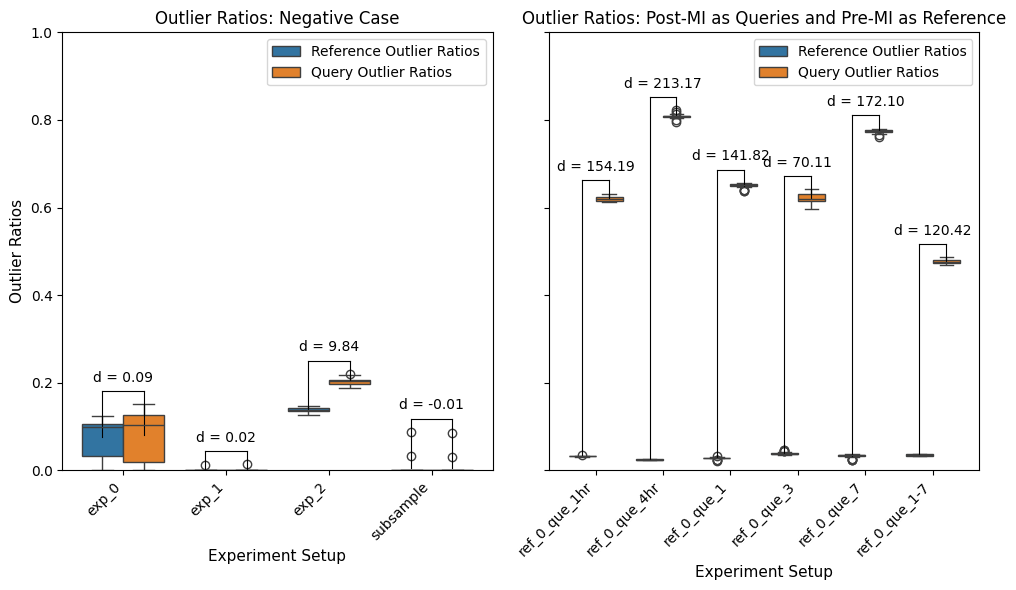

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std if pooled_std != 0 else np.nan

def prepare_plot_data(df, que_col, ref_col):
    # Rename for consistency
    df = df.rename(columns={
        que_col: 'Query Outlier Ratios',
        ref_col: 'Reference Outlier Ratios'
    })

    # Melt into long format
    long_df = df.melt(id_vars='PROBLEM_KEY',
                      value_vars=['Query Outlier Ratios', 'Reference Outlier Ratios'],
                      var_name='Dataset',
                      value_name='Outlier Ratio')

    # Compute Cohen's d
    cohen_d_vals = {}
    for key, group in df.groupby('PROBLEM_KEY'):
        query_vals = group['Query Outlier Ratios'].dropna().values
        ref_vals = group['Reference Outlier Ratios'].dropna().values
        if len(query_vals) > 1 and len(ref_vals) > 1:
            d = cohens_d(query_vals, ref_vals)
            cohen_d_vals[key] = d
        else:
            cohen_d_vals[key] = np.nan

    return long_df, cohen_d_vals

def plot_metrics(ax, long_df, cohen_d_vals, title):
    hue_order = ['Reference Outlier Ratios', 'Query Outlier Ratios']
    sns.boxplot(data=long_df, x='PROBLEM_KEY', y='Outlier Ratio', hue='Dataset',
                hue_order=hue_order, ax=ax)

    ax.tick_params(labelsize=10)
    ax.set_xlabel("Experiment Setup", fontsize=11)
    ax.set_ylabel("Outlier Ratios", fontsize=11)
    ax.set_title(title, fontsize=12)

    # Rotate x-tick labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove legend title
    ax.legend_.set_title(None)

    # Draw prongs at mean values
    problem_keys = long_df['PROBLEM_KEY'].unique()
    offset = 0.2
    for i, key in enumerate(problem_keys):
        group_vals = long_df[long_df['PROBLEM_KEY'] == key]
        outlier_vals = group_vals[group_vals['Dataset'] == 'Reference Outlier Ratios']['Outlier Ratio']
        query_vals = group_vals[group_vals['Dataset'] == 'Query Outlier Ratios']['Outlier Ratio']

        outlier_mean = outlier_vals.mean()
        query_mean = query_vals.mean()
        outlier_max = outlier_vals.max()
        query_max = query_vals.max()
        y_prong = max(outlier_max, query_max) + 0.03

        x_outlier = i - offset
        x_query = i + offset

        ax.plot([x_outlier, x_outlier], [outlier_mean, y_prong], color='black', linewidth=0.8)
        ax.plot([x_query, x_query], [query_mean, y_prong], color='black', linewidth=0.8)
        ax.plot([x_outlier, x_query], [y_prong, y_prong], color='black', linewidth=0.8)

        d_val = cohen_d_vals.get(key, np.nan)
        if not np.isnan(d_val):
            ax.text(i, y_prong + 0.015, f"d = {d_val:.2f}",
                    ha='center', va='bottom', fontsize=10)

    ax.set_ylim([0, 1])

# --- Prepare both datasets ---

# metrics: original table
metrics_long, cohen_d_metrics = prepare_plot_data(metrics, 'fpr', 'outlier_ratio_ref')

# metrics_positive: second table
metrics_pos_long, cohen_d_pos = prepare_plot_data(metrics_positive, 'outlier_ratio_que', 'outlier_ratio_ref')

# --- Plot side-by-side ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

plot_metrics(ax1, metrics_long, cohen_d_metrics, "Outlier Ratios: Negative Case")
plot_metrics(ax2, metrics_pos_long, cohen_d_pos, "Outlier Ratios: Post-MI as Queries and Pre-MI as Reference")

plt.tight_layout()
plt.savefig("negative vs positive.svg")
plt.show()
